# Data Cleaning and Exploration

In this notebook, we clean, parse, and explore the structured musical data extracted from MIDI files.  
The goal is to understand the nature of the features we extracted, ensure their consistency, and identify potential preprocessing steps required for modeling.

In [2]:
import ast
import os
import re
import shutil
from collections import Counter
from fractions import Fraction
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from music21 import chord, converter, instrument, key, meter, note, tempo

### Load Dataset

In [3]:
def safe_parse_all_columns_df(df):
    """
    Parse all columns in a DataFrame to numeric, coercing errors.
    """
    df['notes'] = df['notes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['chords'] = df['chords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['velocities'] = df['velocities'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['durations'] = df['durations'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['offsets'] = df['offsets'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['ordered_events'] = df['ordered_events'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df

def load_dataframe_from_two_csvs(file1, file2):
    """
    Load and concatenate two CSV files into a single pandas DataFrame.
    """
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    full_df = pd.concat([df1, df2], ignore_index=True)
    full_df = safe_parse_all_columns_df(full_df)

    return full_df

def save_dataframe_to_two_csvs(df, file1, file2):
    """
    Split a DataFrame in half and save it into two CSV files.
    """
    halfway = len(df) // 2
    df.iloc[:halfway].to_csv(file1, index=False)
    df.iloc[halfway:].to_csv(file2, index=False)

def load_dataframe_from_one_csv(file):
    """
    Load a DataFrame from a single CSV file.
    """
    df = pd.read_csv(file)
    
    return df

def save_dataframe_to_one_csv(df, file):
    """
    Save a DataFrame to a single CSV file.
    """
    df.to_csv(file, index=True)

def load_reconstructed_events(file):
    """
    Loads the reconstructed events CSV and safely parses the 'sequence' column,
    converting notes to integers and chords to lists of integers.
    """
    df = pd.read_csv(file)

    def safe_parse(seq_str):
        try:
            parsed = ast.literal_eval(seq_str)
            if not isinstance(parsed, list):
                raise ValueError("Parsed sequence is not a list")

            normalized = []
            for el in parsed:
                if isinstance(el, list):
                    normalized.append([int(x) for x in el])
                else:
                    normalized.append(int(el))
            return normalized

        except Exception as e:
            print(f"Error parsing sequence: {seq_str}")
            raise e

    df['sequence'] = df['sequence'].apply(safe_parse)
    return df

## Dataset Overview

Before diving into detailed feature analysis, we begin with a preliminary inspection of the dataset.  
The goal is to identify potential issues that may require preprocessing, such as missing values, inconsistent data types, or unexpected formats.

This step ensures that the data is clean, well-structured, and ready for the next stages of analysis and modeling.

In [4]:
root = 'data_preprocessed/'
file1 = root + 'data_part1.csv'
file2 = root + 'data_part2.csv'

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df = pd.concat([df1, df2], ignore_index=True)

print("The columns in the dataset are:")
print(df.columns)
print("The number of values in the dataset is:", len(df))

if (len(df) == len(df1) + len(df2)):
    print("The number of values in the dataset is correct.")

The columns in the dataset are:
Index(['file_name', 'instrument', 'track_names', 'notes', 'chords',
       'velocities', 'durations', 'offsets', 'tempos', 'time_signatures',
       'key_signatures', 'ordered_events'],
      dtype='object')
The number of values in the dataset is: 2775
The number of values in the dataset is correct.


In [7]:
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

Missing values per column:
Series([], dtype: int64)


Sequence length stats:
count     2775.000000
mean      1627.628468
std        926.926469
min         30.000000
25%       1075.500000
50%       1486.000000
75%       1992.000000
max      17054.000000
Name: ordered_events_len, dtype: float64


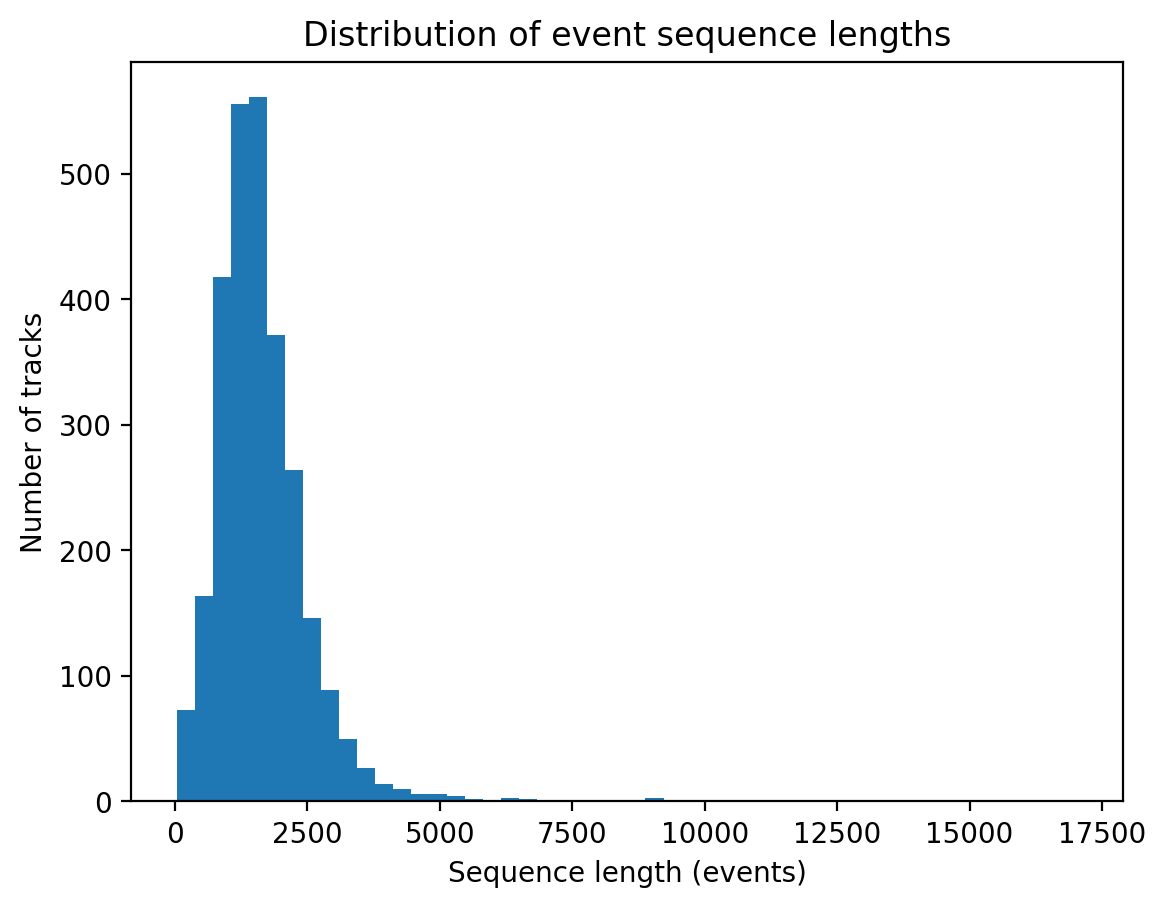

In [8]:
df["ordered_events_len"] = df["ordered_events"].apply(eval).apply(len)

print("Sequence length stats:")
print(df["ordered_events_len"].describe())

plt.hist(df["ordered_events_len"], bins=50)
plt.xlabel("Sequence length (events)")
plt.ylabel("Number of tracks")
plt.title("Distribution of event sequence lengths")
plt.show()

## Feature Distributions

We now examine the distributions of key musical features extracted from the MIDI files, such as notes, chords, velocities, durations, offsets, and metadata like tempo and key signatures.

Analyzing these distributions helps us understand the musical diversity of the dataset, detect outliers, and assess whether further normalization or filtering is necessary before training generative models.

### Instrument

In [ ]:
print("Instrument column summary:")
print(df['instrument'].describe())
print("Unique values:", df['instrument'].nunique())
print("Most common values:")
print(df['instrument'].value_counts().head(10))

Instrument column summary:
count            2775
unique              1
top       ['Unknown']
freq             2775
Name: instrument, dtype: object
Unique values: 1
Most common values:
instrument
['Unknown']    2775
Name: count, dtype: int64


Most of the entries seem to lack this information or report a generic label such as "Unknown".
Given the dataset context, we assume that the tracks represent solo piano performances.

### Notes

In [ ]:
def midi_to_name_note(n):
    """
    Convert a MIDI note number to its note name (e.g., 60 → C4).
    If conversion fails, return the original value as string.
    """
    try:
        return note.Note(n).nameWithOctave
    except:
        return str(n)

In [ ]:
all_notes = []

for row in df['notes'].dropna():
    if isinstance(row, str):
        try:
            notes_list = ast.literal_eval(row)
        except Exception:
            continue
    else:
        notes_list = row
    all_notes.extend(notes_list)

notes_series = pd.Series(all_notes)
top_notes = notes_series.value_counts().head(10)

print("Summary of all notes in the dataset:")
print(notes_series.describe())

print("\nMost common notes:")
for midi_val, count in top_notes.items():
    print(f"{midi_to_name_note(midi_val)} ({midi_val}): {count} times")

Summary of all notes in the dataset:
count    2.730308e+06
mean     6.216901e+01
std      1.432184e+01
min      2.100000e+01
25%      5.300000e+01
50%      6.200000e+01
75%      7.200000e+01
max      1.080000e+02
dtype: float64

Most common notes:
F4 (65): 95563 times
G4 (67): 95028 times
C4 (60): 94973 times
D4 (62): 89063 times
C5 (72): 87045 times
B-4 (70): 78955 times
E-4 (63): 78195 times
A4 (69): 76656 times
G3 (55): 75575 times
E4 (64): 74487 times


### Chords

In [ ]:
def midi_to_chord(n):
    """
    Convert a list of MIDI pitch values into a chord name using music21.
    If conversion fails, return the original list as a string.
    """
    try:
        return chord.Chord(midin_notes).pitchedCommonName
    except:
        return str(n)

In [ ]:
all_chords = []

for row in df['chords'].dropna():
    if isinstance(row, str):
        try:
            notes_list = ast.literal_eval(row)
        except Exception:
            continue
    else:
        notes_list = row
    all_chords.extend(notes_list)

chords_series = pd.Series(all_chords)
top_chords = chords_series.value_counts().head(10)

print("Summary of all chords in the dataset:")
print(chords_series.describe())

print("\nMost common chords:")
for midi_val, count in top_chords.items():
    print(f"{midi_to_chord(midi_val)} ({midi_val}): {count} times")


Most common chords:
[60, 65] ([60, 65]): 3818 times
[60, 63] ([60, 63]): 3729 times
[62, 65] ([62, 65]): 3688 times
[58, 70] ([58, 70]): 3654 times
[54, 60] ([54, 60]): 3594 times
[55, 60] ([55, 60]): 3578 times
[58, 63] ([58, 63]): 3576 times
[60, 72] ([60, 72]): 3569 times
[57, 62] ([57, 62]): 3545 times
[55, 67] ([55, 67]): 3406 times


### Velocities

In [ ]:
print("Velocities column summary:")
print(df['velocities'].describe())
print("Unique values:", df['velocities'].nunique())
print("Most common values:")
print(df['velocities'].value_counts().head(10))

Velocities column summary:
count                                                  2775
unique                                                 2775
top       [51, 35, 52, 48, 48, 50, 50, 50, 49, 42, 56, 4...
freq                                                      1
Name: velocities, dtype: object
Unique values: 2775
Most common values:
velocities
[51, 35, 52, 48, 48, 50, 50, 50, 49, 42, 56, 49, 49, 62, 39, 45, 56, 53, 52, 49, 43, 64, 50, 61, 64, 59, 55, 71, 60, 55, 56, 53, 55, 53, 52, 56, 59, 59, 50, 49, 51, 49, 50, 46, 46, 55, 61, 48, 54, 56, 51, 62, 66, 55, 66, 62, 65, 59, 51, 59, 63, 56, 64, 54, 49, 62, 50, 69, 58, 53, 56, 46, 68, 60, 50, 51, 53, 49, 60, 50, 43, 44, 53, 55, 57, 55, 58, 62, 59, 56, 50, 51, 52, 55, 49, 49, 50, 55, 52, 47, 54, 58, 50, 52, 61, 51, 63, 50, 55, 45, 44, 54, 59, 56, 71, 59, 68, 60, 42, 47, 50, 63, 58, 56, 64, 57, 66, 55, 62, 58, 65, 69, 69, 56, 73, 48, 57, 54, 49, 52, 60, 51, 53, 49, 61, 57, 69, 56, 55, 64, 72, 61, 64, 44, 62, 60, 53, 58, 71, 51, 63, 54, 6

### Durations

In [ ]:
print("Durations column summary:")
print(df['durations'].describe())
print("Unique values:", df['durations'].nunique())
print("Most common values:")
print(df['durations'].value_counts().head(10))

Durations column summary:
count                                                  2775
unique                                                 2775
top       [0.25, 2.5, 0.25, Fraction(1, 3), Fraction(1, ...
freq                                                      1
Name: durations, dtype: object
Unique values: 2775
Most common values:
durations
[0.25, 2.5, 0.25, Fraction(1, 3), Fraction(1, 3), 0.25, Fraction(1, 3), 0.25, Fraction(1, 3), 0.75, 1.5, Fraction(1, 3), 0.25, 1.0, Fraction(1, 3), Fraction(1, 3), 1.75, 0.25, Fraction(17, 12), Fraction(1, 3), 1.0, 0.25, 0.25, 0.25, 0.25, Fraction(1, 3), Fraction(1, 3), Fraction(1, 3), Fraction(1, 3), Fraction(2, 3), 0.25, 0.25, 0.25, Fraction(1, 3), 2.0, Fraction(1, 3), Fraction(4, 3), Fraction(1, 3), Fraction(1, 3), 1.0, 0.25, 2.0, 1.25, 0.25, 0.5, Fraction(17, 12), Fraction(1, 3), 0.5, 0.25, 0.25, 2.0, 1.5, Fraction(1, 3), Fraction(1, 3), 0.25, 0.25, 2.0, 0.25, 1.75, 0.25, Fraction(1, 3), Fraction(1, 3), Fraction(1, 3), Fraction(1, 3), Fracti

We observed that some entries in the `durations` column are stored as `Fraction` objects, likely due to the symbolic nature of musical timing.

To enable numerical analysis and plotting, we convert all values to floats with a consistent level of precision.


In [ ]:
def parse_and_flatten_durations(durations_column, precision=4):
    """
    Convert and flatten the durations column from stringified Fraction objects to rounded floats.
    """
    all_durations = []
    cleaned_rows = []

    for row in durations_column.dropna():
        cleaned_row = []
        if isinstance(row, str):
            input_str = row.strip()[1:-1]
            try:
                parsed_items = eval(f"[{input_str}]", {"Fraction": Fraction})
            except Exception:
                parsed_items = []

            for item in parsed_items:
                rounded = round(float(item), precision)
                cleaned_row.append(rounded)
                all_durations.append(rounded)

        else:
            for item in row:
                try:
                    rounded = round(float(item), precision)
                    cleaned_row.append(rounded)
                    all_durations.append(rounded)
                except Exception:
                    continue

        cleaned_rows.append(cleaned_row)

    durations_column.update(pd.Series([str(row) for row in cleaned_rows], index=durations_column.dropna().index))

    return all_durations

all_durations = parse_and_flatten_durations(df['durations'])
print(f"Mean duration: {np.mean(all_durations):.4f}")
print(f"Standard deviation of durations: {np.std(all_durations):.4f}")

Mean duration: 0.9670
Standard deviation of durations: 1.2823


In [ ]:
root = 'data_preprocessed/'
file1 = root + 'data_part2_1.csv'
file2 = root + 'data_part2_2.csv'
save_dataframe_to_two_csvs(df, file1, file2)

### Offsets

In [ ]:
print("Offsets column summary:")
print(df['offsets'].describe())
print("Unique values:", df['offsets'].nunique())
print("Most common values:")
print(df['offsets'].value_counts().head(10))

Offsets column summary:
count                                                  2775
unique                                                 2775
top       [0.5, 1.25, 3.75, Fraction(5, 3), Fraction(7, ...
freq                                                      1
Name: offsets, dtype: object
Unique values: 2775
Most common values:
offsets
[0.5, 1.25, 3.75, Fraction(5, 3), Fraction(7, 3), 2.75, 3.5, 0.25, 0.75, Fraction(4, 3), 2.25, Fraction(4, 3), 2.0, 2.25, Fraction(10, 3), Fraction(11, 3), 2.25, Fraction(7, 3), 0.0, Fraction(1, 3), Fraction(2, 3), 1.75, 2.0, 2.25, 2.5, 3.0, Fraction(11, 3), 1.0, Fraction(4, 3), 3.0, 0.0, 0.0, 0.5, 1.0, Fraction(4, 3), 3.5, 0.0, 2.0, Fraction(7, 3), 2.75, 3.75, 0.5, 2.75, 2.75, 3.0, 0.0, Fraction(1, 3), 0.75, 1.25, 1.75, 2.0, Fraction(1, 3), Fraction(8, 3), 3.0, Fraction(10, 3), 3.75, Fraction(1, 3), 3.5, 0.0, 0.25, 0.5, Fraction(4, 3), 1.75, Fraction(7, 3), Fraction(8, 3), 3.5, 0.75, 1.75, Fraction(8, 3), 3.0, 3.25, 3.5, 0.75, 2.0, Fraction(11, 3), F

To enable numerical analysis and plotting, we convert all values to floats with a consistent level of precision.

In [ ]:
def parse_and_flatten_offsets(offsets_column, precision=4):
    """
    Convert and flatten the offsets column from stringified Fraction objects to rounded floats.
    """
    all_offsets = []
    cleaned_rows = []

    for row in offsets_column.dropna():
        cleaned_row = []
        if isinstance(row, str):
            input_str = row.strip()[1:-1]
            try:
                parsed_items = eval(f"[{input_str}]", {"Fraction": Fraction})
            except Exception:
                parsed_items = []

            for item in parsed_items:
                rounded = round(float(item), precision)
                cleaned_row.append(rounded)
                all_offsets.append(rounded)

        else:
            for item in row:
                try:
                    rounded = round(float(item), precision)
                    cleaned_row.append(rounded)
                    all_offsets.append(rounded)
                except Exception:
                    continue

        cleaned_rows.append(cleaned_row)

    offsets_column.update(pd.Series([str(row) for row in cleaned_rows], index=offsets_column.dropna().index))

    return all_offsets

all_offsets = parse_and_flatten_offsets(df['offsets'])
print(f"Mean offset: {np.mean(all_offsets):.4f}")
print(f"Standard deviation of offset: {np.std(all_offsets):.4f}")

Mean offset: 1.5558
Standard deviation of offsets: 1.2686


In [ ]:
root = 'data_preprocessed/'
file1 = root + 'data_part2_1.csv'
file2 = root + 'data_part2_2.csv'
save_dataframe_to_two_csvs(df, file1, file2)

### Tempos

In [ ]:
print("Tempos column summary:")
print(df['tempos'].describe())
print("Unique values:", df['tempos'].nunique())
print("Most common values:")
print(df['tempos'].value_counts().head(10))

Tempos column summary:
count        2775
unique          1
top       [120.0]
freq         2775
Name: tempos, dtype: object
Unique values: 1
Most common values:
tempos
[120.0]    2775
Name: count, dtype: int64


### Time signatures

In [ ]:
print("Time signatures column summary:")
print(df['time_signatures'].describe())
print("Unique values:", df['time_signatures'].nunique())
print("Most common values:")
print(df['time_signatures'].value_counts().head(10))

Time signatures column summary:
count        2775
unique          1
top       ['4/4']
freq         2775
Name: time_signatures, dtype: object
Unique values: 1
Most common values:
time_signatures
['4/4']    2775
Name: count, dtype: int64


### Key signatures

In [ ]:
print("Key signatures column summary:")
print(df['key_signatures'].describe())
print("Unique values:", df['key_signatures'].nunique())
print("Most common values:")
print(df['key_signatures'].value_counts().head(10))

Key signatures column summary:
count     2775
unique       1
top         []
freq      2775
Name: key_signatures, dtype: object
Unique values: 1
Most common values:
key_signatures
[]    2775
Name: count, dtype: int64


### Ordered events

The `ordered_events` column encodes the temporal structure of each track by recording the sequence of musical events—either single notes or chords—as they appear over time.

In [ ]:
print("Ordered events column summary:")
print(df['ordered_events'].describe())
print("Unique values:", df['ordered_events'].nunique())
print("Most common values:")
print(df['ordered_events'].value_counts().head(10))

Ordered events column summary:
count                                                  2775
unique                                                 2775
top       ['n', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'n', ...
freq                                                      1
Name: ordered_events, dtype: object
Unique values: 2775
Most common values:
ordered_events
['n', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'n', 'n', 'c', 'c', 'n', 'n', 'n', 'n', 'c', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'c', 'n', 'n', 'c', 'c', 'c', 'c', 'c', 'n', 'c', 'n', 'n', 'n', 'n', 'c', 'c', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'c', 'c', 'n', 'n', 'n', 'c', 'c', 'n', 'n', 'n', 'c', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'c', 'c', 'c', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'c', 'n', 'n', 'c', 'n', 'n', 'c', 'c', 'n', 'n', 'c', 'n', 'c', 'c', 'n', 'n', 'n', 'c

In [5]:
def parse_and_flatten_events(events_column, precision=4):
    """
    Count the number of note ('n') and chord ('c') events in the ordered_events column.
    """
    events_count = dict()
    events_count['n'] = 0
    events_count['c'] = 0


    for row in events_column.dropna():
        cleaned_row = []
        if isinstance(row, str):
            input_str = row.strip()[1:-1]
            try:
                parsed_items = input_str.split(',')
            except Exception:
                parsed_items = []

            for item in parsed_items:
                item = item.strip()
                item = item.strip("\'\"")
                events_count[item] += 1

    return events_count

all_events = parse_and_flatten_events(df['ordered_events'])
print(f"Fraction of notes over total events: {(all_events['n'] / (all_events['n'] + all_events['c'])):.4f}")
print(f"Fraction of chords over total events: {(all_events['c'] / (all_events['n'] + all_events['c'])):.4f}")

Fraction of notes over total events: 0.6045
Fraction of chords over total events: 0.3955


### Save to CSV

In [ ]:
root = 'data_processed/'
file1 = root + 'data_part1.csv'
file2 = root + 'data_part2.csv'
save_dataframe_to_two_csvs(df, file1, file2)

df = load_dataframe_from_two_csvs(file1, file2)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001EDC24A2840>>
Traceback (most recent call last):
  File "C:\Users\busat\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\busat\miniconda3\Lib\threading.py", line 1533, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


### Consistency Check

We verify that all musical feature sequences in each track are properly aligned.

For every row, we check that:
- The total number of notes and chords matches the number of durations.
- The durations, velocities, offsets, and ordered events all have the same length.

This ensures the dataset is structurally sound and ready for sequence-based modeling.

In [51]:
root = 'data_processed/'
file1 = root + 'data_part1.csv'
file2 = root + 'data_part2.csv'
df = load_dataframe_from_two_csvs(file1, file2)

In [ ]:
def check_dataset_consistency(df):
    """
    Check that each row in the dataset has aligned sequence lengths for all musical features.
    """
    failed_rows = []

    for i in range(len(df)):
        row = df.iloc[i]
        try:
            notes = row['notes']
            chords = row['chords']
            durations = row['durations']
            velocities = row['velocities']
            offsets = row['offsets']
            events = row['ordered_events']

            cond1 = len(notes) + len(chords) == len(durations)
            cond2 = len(durations) == len(velocities) == len(offsets) == len(events)

            if not (cond1 and cond2):
                failed_rows.append(i)

        except Exception as e:
            print(f"Error parsing row {i}: {e}")
            failed_rows.append(i)

    total = len(df)
    failed = len(failed_rows)
    passed = total - failed

    print(f"\n Passed: {passed}/{total}")
    print(f" Failed: {failed}/{total}")
    if failed > 0:
        print(f"Indices of failed rows: {failed_rows}")

    return failed_rows

check_dataset_consistency(df)


 Passed: 2775/2775
 Failed: 0/2775


[]

### Plots of Distributions

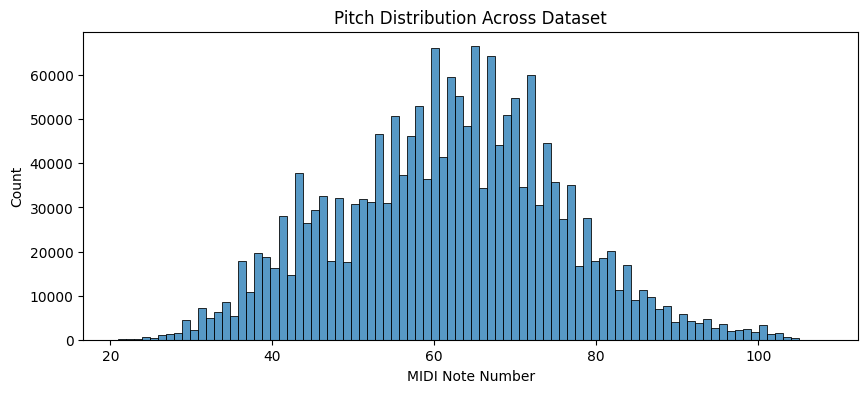

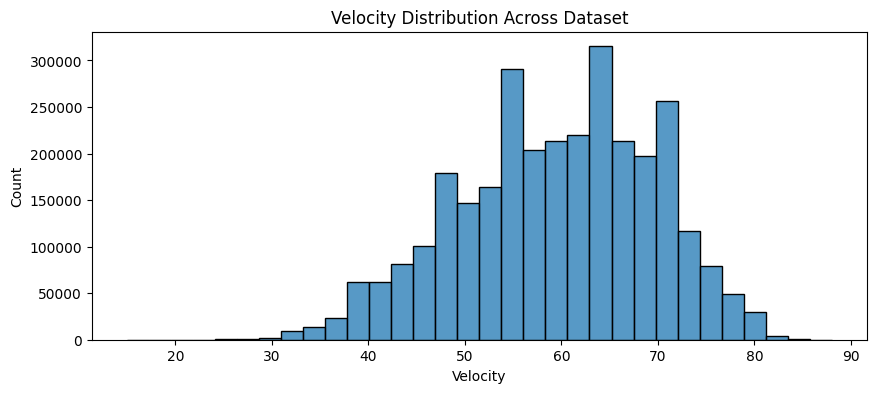

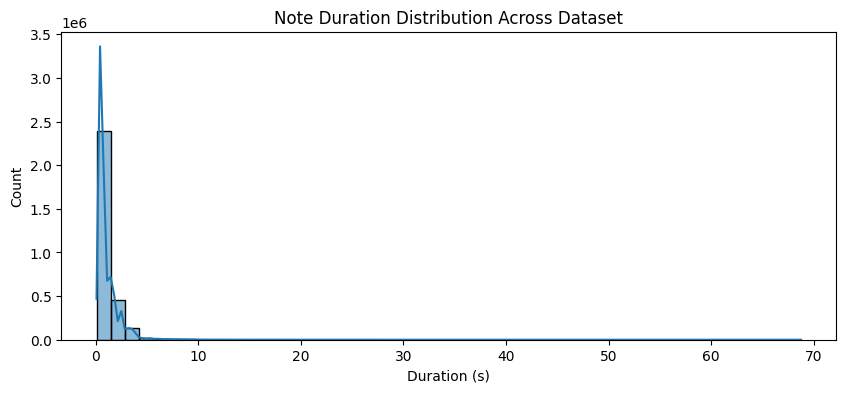

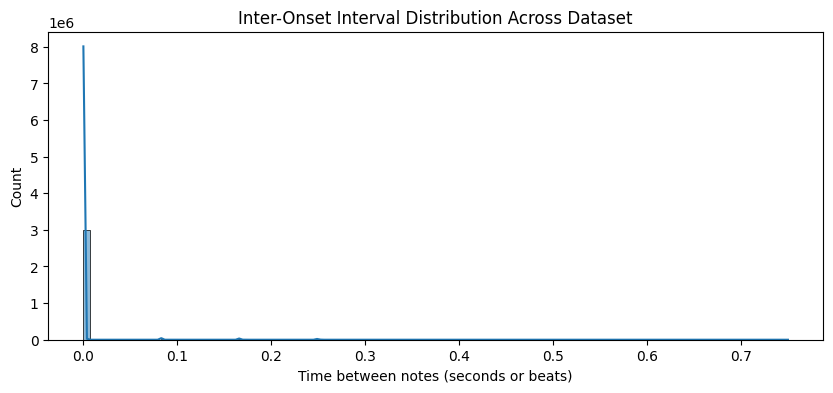

Most common chords: [((60, 63), 2771), ((60, 65), 2720), ((62, 65), 2629), ((58, 63), 2547), ((55, 60), 2526), ((54, 60), 2414), ((60, 64), 2343), ((70, 82), 2307), ((57, 62), 2276), ((72, 84), 2263)]


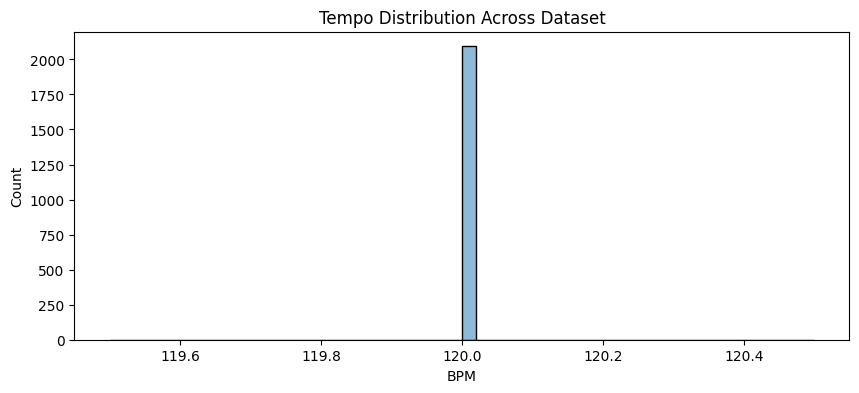

In [ ]:
all_notes = [note for notes_list in df['notes'] for note in notes_list]
all_velocities = [vel for vel_list in df['velocities'] for vel in vel_list]
all_durations = [dur for dur_list in df['durations'] for dur in dur_list]
all_offsets = [off for off_list in df['offsets'] for off in off_list]

plt.figure(figsize=(10,4))
sns.histplot(all_notes, bins=88, kde=False)
plt.title('Pitch Distribution Across Dataset')
plt.xlabel('MIDI Note Number')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(all_velocities, bins=32, kde=False)
plt.title('Velocity Distribution Across Dataset')
plt.xlabel('Velocity')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(all_durations, bins=50, kde=True)
plt.title('Note Duration Distribution Across Dataset')
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

inter_onsets = []
for offsets_list in df['offsets']:
    offsets_list = sorted(offsets_list)
    inter_onsets.extend([j-i for i, j in zip(offsets_list[:-1], offsets_list[1:])])

plt.figure(figsize=(10,4))
sns.histplot(inter_onsets, bins=100, kde=True)
plt.title('Inter-Onset Interval Distribution Across Dataset')
plt.xlabel('Time between notes (seconds or beats)')
plt.ylabel('Count')
plt.show()

all_chords = []
for chords_list in df['chords']:
    for chord in chords_list:
        if isinstance(chord, list):
            all_chords.append(tuple(chord))
        else:
            all_chords.append(chord)

chord_counts = Counter(all_chords)
print("Most common chords:", chord_counts.most_common(10))

all_tempos = [tempo for tempo_list in df['tempos'] for tempo in tempo_list if tempo]
plt.figure(figsize=(10,4))
sns.histplot(all_tempos, bins=50, kde=True)
plt.title('Tempo Distribution Across Dataset')
plt.xlabel('BPM')
plt.ylabel('Count')
plt.show()

## Temporal Dependencies and Predictability



Musical sequences often exhibit strong short- and mid-range dependencies, especially in melody and rhythm.

In this section, we assess whether our dataset shows such temporal patterns by:
- Computing the autocorrelation function (ACF) for each track.
- Evaluating the stationarity of note sequences.

These insights will guide our choice of models, especially those designed to capture sequential structure such as RNNs or Transformers.

### Reconstructing the Event order

In [27]:
def parse_chord_to_list(chord):
    """
    Convert a chord string to a list of integers.
    """
    if isinstance(chord, str):
        print([int(x) for x in chord.split(',') if x.isdigit()])
        return [int(x) for x in chord.split(',') if x.isdigit()]
    return []

def reconstruct_ordered_events(df):
    """
    Reconstruct the ordered list of events (notes and chords) for each song.
    """
    sequences  = []

    for i in range(len(df)):
        idx_note = 0
        idx_chord = 0
        reconstructed = []

        for element in df['ordered_events'][i]:
            if element == 'n':
                reconstructed.append(df['notes'][i][idx_note])
                idx_note += 1
            elif element == 'c':
                parsed_chord = parse_chord_to_list(df['chords'][i][idx_chord])
                reconstructed.append(df['chords'][i][idx_chord])
                idx_chord += 1
            else:
                raise ValueError(f"Unknown event type: {e}")
        
        sequences.append(reconstructed)

    reconstructed_dataset = pd.DataFrame({'sequence': sequences})
    reconstructed_dataset.index.name = 'index'

    return reconstructed_dataset

In [ ]:
save_dataframe_to_one_csv(reconstruct_ordered_events(df), root + 'reconstructed_ordered_events.csv')

In [29]:
reconstructed_dataset = load_reconstructed_events(root + 'reconstructed_ordered_events.csv')

### Autocorrelation Function for the Events

We compute the autocorrelation of each track's pitch sequence using the reconstructed event order. Chords are replaced with the average of their constituent note values to obtain a unified note-level time series.

In [47]:
max_lag = 10
acfs = []

def compute_acf_from_series(series):
    if len(series) < max_lag + 1:
        return [np.nan] * (max_lag + 1)
    return acf(series, nlags=max_lag, fft=False)

for row in reconstructed_dataset['sequence']:
    if isinstance(row, str):
        print(f"Error parsing sequence: {row}")
    if isinstance(row, list):
        for i, el in enumerate(row):
            if isinstance(el, list):
                row[i] = sum(el) / len(el) if el else 0
    
    acfs.append(compute_acf_from_series(row))

acf_df = pd.DataFrame(acfs)

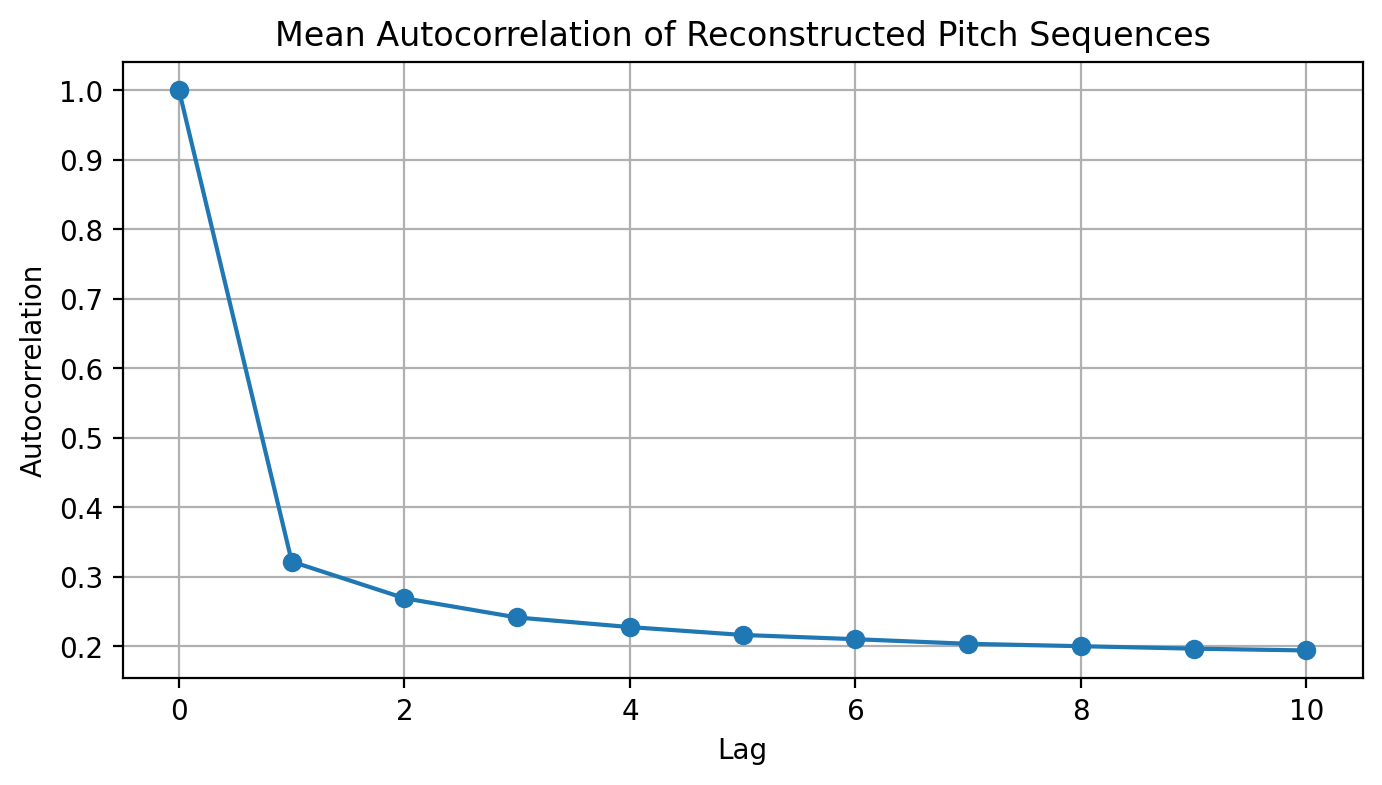

In [46]:
plt.figure(figsize=(8, 4))
plt.plot(acf_df.mean(), marker='o')
plt.title("Mean Autocorrelation of Reconstructed Pitch Sequences")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.show()

The autocorrelation plot shows a clear short-term dependency in pitch sequences, with significant correlation at lag 1 and a gradual decay over time. This supports the use of autoregressive models and confirms that the data is structured and not random.


## Structure and Order

We analyze the internal structure of the reconstructed pitch sequences by computing the most frequent bigrams—pairs of consecutive pitch values.

This helps identify whether certain notes or chords tend to follow one another, which is a key insight for building transition-based or autoregressive models.

A high frequency of identical bigrams (e.g., 62 → 62) suggests temporal persistence and note repetition, typical of sustained tones or rhythmic motifs.


In [52]:
bigrams = Counter()

for row in reconstructed_dataset['sequence']:
    bigrams.update((a, b) for a, b in zip(row[:-1], row[1:]))

print("Most common bigrams (event type transitions):")
for k, v in bigrams.most_common(10):
    print(f"{k[0]} → {k[1]}: {v}")


Most common bigrams (event type transitions):
62 → 62: 8550
60 → 60.0: 8050
65.0 → 65.0: 7764
57 → 57: 7433
67 → 67: 7403
64 → 64: 7346
63.0 → 63.0: 6671
58 → 58: 6619
55 → 55: 6614
69 → 69: 6274


The most common bigrams in the reconstructed pitch sequences are self-repetitions (e.g., 62 → 62, 60 → 60), indicating that notes are often sustained or repeated across consecutive time steps. This reinforces the presence of short-term stability and suggests that models should account for temporal persistence.


## Visualization

To gain an intuitive understanding of the melodic structure, we visualize the pitch trajectory of a sample track.

Each point corresponds to a note or the average of a chord, plotted over discrete time steps.  
This type of plot reveals contours, repetitions, and range, and helps validate whether the reconstructed sequences resemble natural musical phrases.

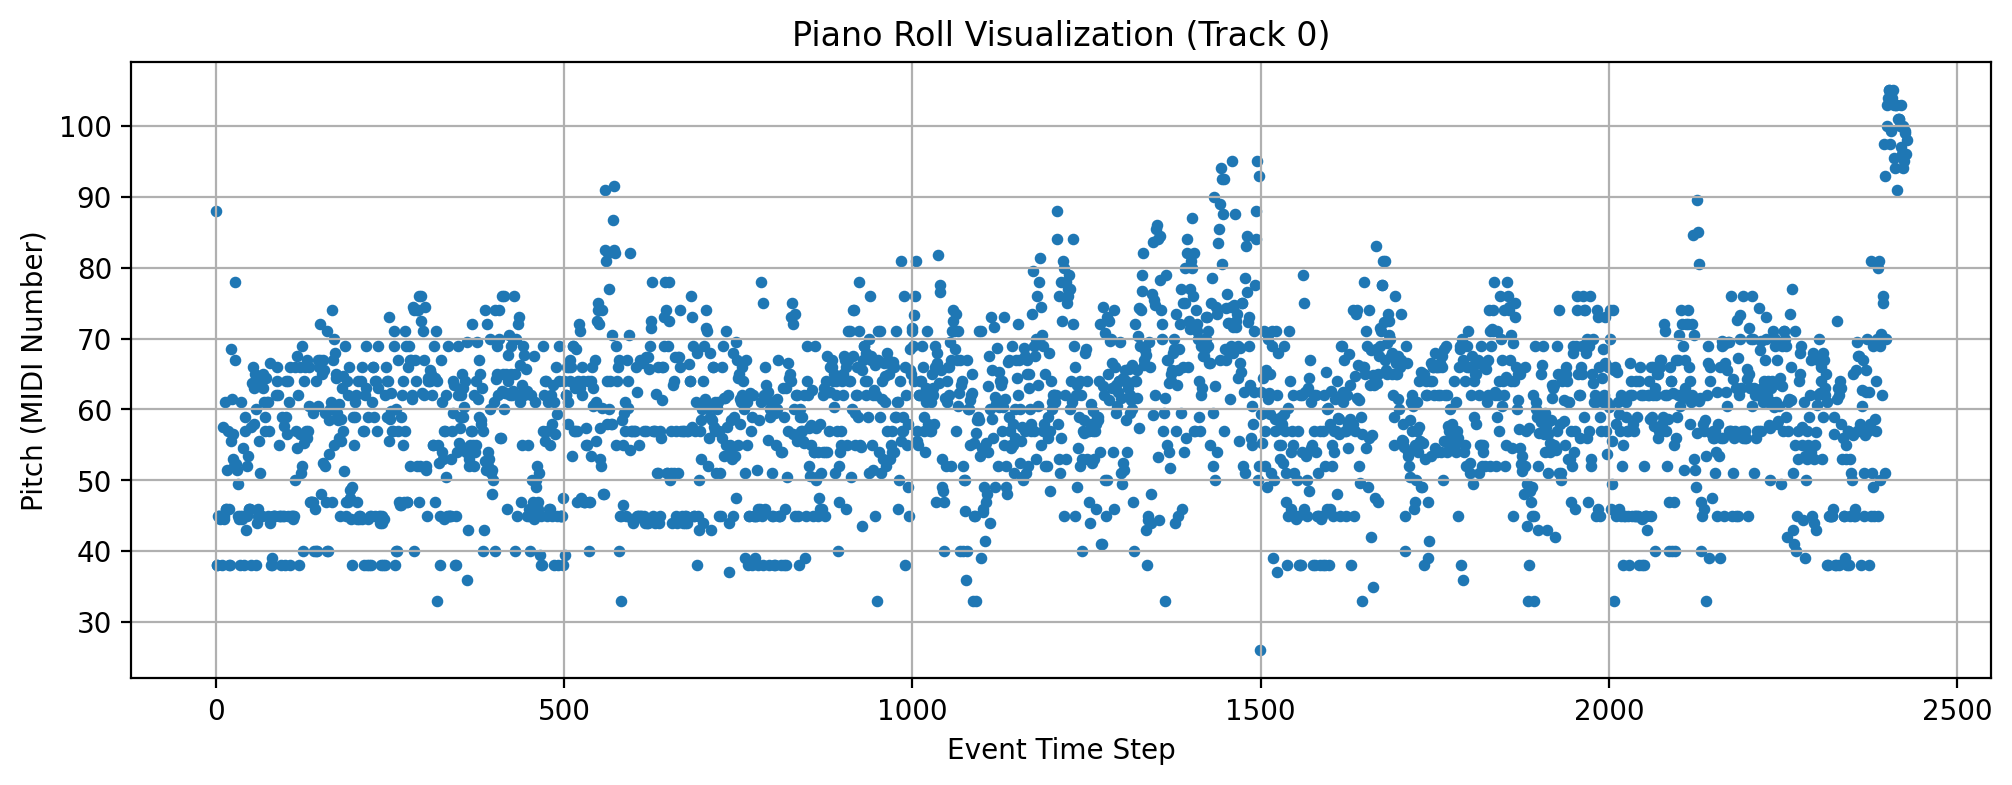

In [ ]:
def extract_pitch_time(events):
    """
    Convert a sequence of notes/chords into a list of (time, pitch) tuples for plotting.
    """
    notes = []
    time = 0
    for e in events:
        if isinstance(e, list):
            for note_val in e:
                notes.append((time, note_val))
        elif isinstance(e, (int, float)):
            notes.append((time, e))
        time += 1
    return notes

sample_events = reconstructed_dataset["sequence"].iloc[0]
if isinstance(sample_events, str):
    sample_events = eval(sample_events)

pitch_time_pairs = extract_pitch_time(sample_events)
times, pitches = zip(*pitch_time_pairs)

plt.figure(figsize=(12, 4))
plt.scatter(times, pitches, s=10, marker='o')
plt.title("Piano Roll Visualization (Track 0)")
plt.xlabel("Event Time Step")
plt.ylabel("Pitch (MIDI Number)")
plt.grid(True)
plt.show()

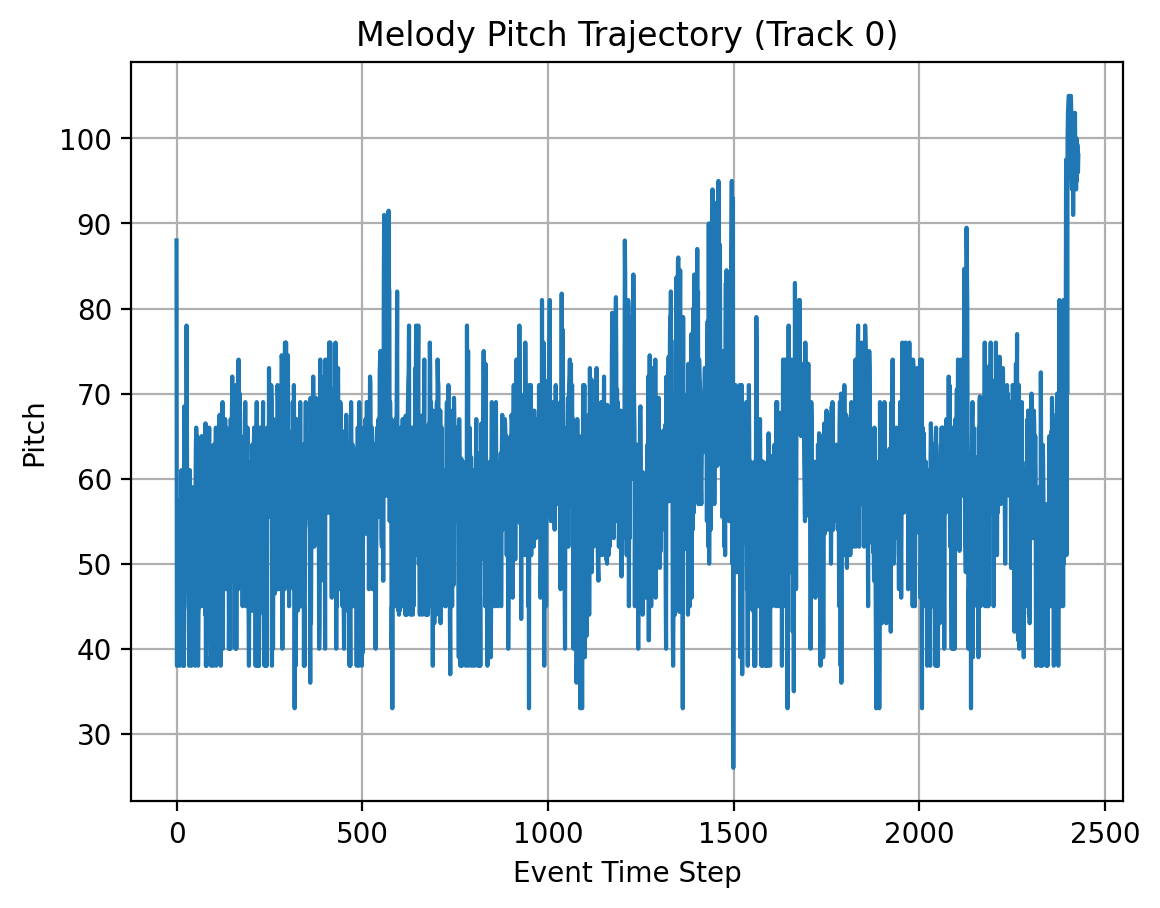

In [ ]:
plt.plot(times, pitches)
plt.title("Melody Pitch Trajectory (Track 0)")
plt.xlabel("Event Time Step")
plt.ylabel("Pitch")
plt.grid(True)
plt.show()